<a href="https://colab.research.google.com/github/juliusberner/oberwolfach_workshop/blob/master/NN_Approximation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

This provides a framework to construct deep neural networks used to efficiently approximating various functions.
* **modular design**: builds on simple network operations and can be easily adapted and extended
* **versatile usage**: convenient mathematical notation and compatible with usual TensorFlow 2.x modules

Theory: 

* [[1]](https://arxiv.org/abs/1709.05289): *Optimal approximation of piecewise smooth functions using deep ReLU neural networks* - Philipp Petersen, Felix Voigtlaender


* [[2]](https://arxiv.org/abs/1809.07669): *DNN Expression Rate Analysis of High-dimensional PDEs: Application to Option Pricing* - Dennis Elbrächter, Philipp Grohs, Arnulf Jentzen, Christoph Schwab


* [[3]](https://arxiv.org/abs/1902.07896): *Error bounds for approximations with deep ReLU neural networks in $W^{s,p}$ norms* - Ingo Gühring, Gitta Kutyniok, Philipp Petersen


* [[4]](https://arxiv.org/abs/1610.01145): *Error bounds for approximations with deep ReLU networks* - Dmitry Yarotsky


* [[5]](https://arxiv.org/abs/1602.04485): *Benefits of depth in neural networks* - Matus Telgarsky


* [[6]](https://arxiv.org/abs/1905.04992): *Towards a regularity theory for ReLU networks -- chain rule and global error estimates* - Julius Berner, Dennis Elbrächter, Philipp Grohs, Arnulf Jentzen 


* [[7]](https://www.sam.math.ethz.ch/sam_reports/counter/ct.php?file=/sam_reports/reports_final/reports2019/2019-07_fp.pdf): *Deep ReLU Networks and High-Order Finite Element Methods* - Joost Opschoor, Philipp Petersen, Christoph Schwab

If you have any questions, please feel free to contact me:  julius.berner@univie.ac.at

## Imports

In [1]:
import os
from pathlib import Path

from ipywidgets import interact
from IPython.display import display_svg, Image, SVG
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# using files from github repository also from colab
module_path = Path("modules")
figures_path = Path("figures")
if not all(p.exists() and p.is_dir() for p in [module_path, figures_path]):
    repo_path = Path('oberwolfach_workshop')
    if not (repo_path.exists() and repo_path.is_dir()):
        os.system(f"git clone https://github.com/juliusberner/{repo_path.name}.git -q")
    os.chdir(repo_path)

from modules.utils import plot_1d
from modules import nn_constructions as nn
from modules.nn_constructions import P, R, D

## Neural Network Parametrizations, Realizations, and Derivatives

### Parametrizations

* Tutorial: [Python classes](https://docs.python.org/3/tutorial/classes.html)

We follow a mathematical definition due to [P. Petersen and F. Voigtländer [1]](https://arxiv.org/abs/1709.05289):

1. For a given architecture $N=(N_0,\dots,N_L)$ define a neural network parametrization $\Phi$ to be a finite sequence of matrix-vector pairs
    
   $$\color{green} {\Phi:=((W_k,b_k))_{k=1}^L} $$
   
   where  $W_k\in\mathbb{R}^{N_{k-1}\times N_{k}}$ and $b_k\in\mathbb{R}^{N_k}$.

In [2]:
# shallow neural net
a1 = np.array([[1.0, 1.0]])
b1 = np.array([0.0, -1])
a2 = np.array([[1], [-1]])
b2 = np.array([0.0])
psi = P([(a1, b1), (a2, b2)], name="my parametrization")

psi

my parametrization: [(array([[1., 1.]]), array([ 0., -1.])), (array([[ 1],
       [-1]]), array([0.]))]

In [3]:
psi.describe()

'Depth: 2, Width: 2, Magnitude: 1.0, #Parameters: 7, Connectivity: 5'

In [4]:
[a for a in dir(psi) if not a.startswith("_")]

['arch',
 'biases',
 'connectivity',
 'depth',
 'describe',
 'eps',
 'in_dim',
 'magnitude',
 'name',
 'num_parameters',
 'out_dim',
 'parameters',
 'weights',
 'width']

In [5]:
psi.arch

[1, 2, 1]

In [6]:
P("hat")

hat: [(array([[1., 1., 1.]]), array([ 0. , -0.5, -1. ])), (array([[ 2.],
       [-4.],
       [ 2.]]), array([0.]))]

### Realization
* Tutorial: [Custom tf layers and models](https://www.tensorflow.org/guide/keras/custom_layers_and_models)

For a given activation function $\rho\colon\mathbb{R}\to\mathbb{R}$ define its realization $\mathcal{R}_\rho\Phi\colon \mathbb{R}^{1\times N_0}\to\mathbb{R}^{1\times N_L}$ by 

  $$\color{green}{\mathcal{R}_\rho\Phi := \mathcal{A}_L\circ \rho \circ  \mathcal{A}_{L-1}          \circ\dots\circ \rho\circ\mathcal{A}_1}$$

  with $\color{green}{\mathcal{A}_k(x):=xW_k + b_k}$ and $\rho$ applied componentwise. 
  
  Note: In order to stay compatible with TensorFlow we multiply the input from left as a row vector.

In [7]:
realization = R(psi)
realization([[0.5]])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5]], dtype=float32)>

In [8]:
realization([[0.0], [0.5], [1.0]]).numpy()

array([[0. ],
       [0.5],
       [1. ]], dtype=float32)

In [9]:
realization.summary()

Model: "relu-realization of my parametrization"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_0 (AffineLayer)        multiple                  4         
_________________________________________________________________
layer_1 (AffineLayer)        multiple                  3         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


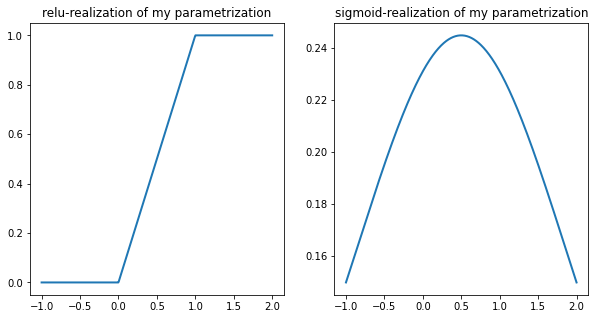

In [10]:
realizations = [realization, R(psi, act=tf.nn.sigmoid)]
plot_1d(
    *realizations, titles=[r.name for r in realizations], interval=[-1, 2], sharey=False
)

### Derivative
* Tutorial: [Automatic differentiation in tf](https://www.tensorflow.org/tutorials/customization/autodiff3) 

Define the derivative (w.r.t. the input) $\mathcal{D}_\rho\Phi\colon\mathbb{R}^{1\times N_0}\to\mathbb{R}^{N_L\times N_0}$ by 

  $$\color{green}{\mathcal{D}_\rho\Phi:=W^T_L\cdot \operatorname{diag}(D\rho(\mathcal{R}^{L}_\rho\Phi))\cdot W^T_{L-1}\cdot\ldots\cdot \operatorname{diag}(D\rho(\mathcal{R}_\rho^{1}\Phi))\cdot W_1^T}$$ 
  
  with $\color{green}{\mathcal{R}^K_\rho\Phi:=\mathcal{R}_\rho((W_k,b_k))_{k=1}^{K}}$ and $D\rho$ applied componentwise.

  Note: If $\rho$ is only a.e. differentiable (i.e. locally Lipschitz continuous) we use the extended derivative 

  $$\bar{D}\rho(x) := \begin{cases} D\rho(x), & \rho \text{ is differentiable at } x \\ 0 &\text{else.}  \end{cases} $$

  Then it holds that the classical derivative of the realization function  coincides with the  neural network derivative almost everywhere, i.e. 

  $$\color{green}{\mathcal{D}_\rho\Phi=D\mathcal{R}_\rho\Phi \quad a.e.}$$

  see [[2]](https://arxiv.org/abs/1905.04992). Observe that all realizations with locally Lipschitz continuous activation function are itself locally Lipschitz continuous and a.e. classically differentiable (due to Rademacher's theorem) with its weak derivative a.e. coinciding with its classical derivative.

In [11]:
derivative = D(psi)
derivative([[0.5], [0.0]]).numpy()

array([[1.],
       [0.]], dtype=float32)

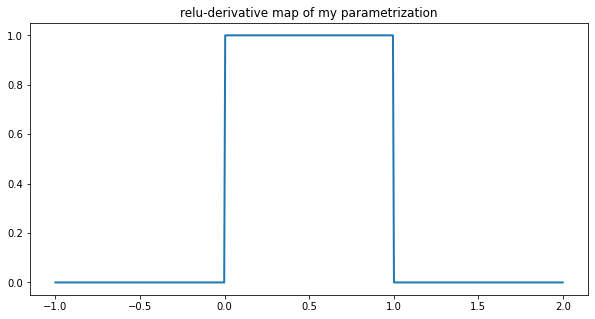

In [12]:
plot_1d(derivative, titles=[derivative.name], interval=[-1, 2])

## Operations on Parametrizations

We can define various operations on neural networks parametrizations achieving 
* Concatenation (Composition)
* Parallelization
* Affine Combinations

of the corresponding realization functions, see [[1]](https://arxiv.org/abs/1709.05289), [[2]](https://arxiv.org/abs/1809.07669), [[3]](https://arxiv.org/abs/1902.07896).

For instance, we define the concatenation with $\Psi\!=\!((\tilde{A}_k,\tilde{b}_k))_{k=1}^{\tilde{L}}$ by


 $$\Psi\circ\Phi:=\big(((A_k,b_k))_{k=1}^{L-1},(A_{L}\tilde{A}_1,b_{L}^T\tilde{A}_1 +\tilde{b}_1),((\tilde{A}_k,\tilde{b}_k))_{k=2}^{\tilde{L}}\big)$$


and it holds that $\mathcal{R}_\rho(\Psi\circ\Phi) = \mathcal{R}_\rho(\Psi) \circ\mathcal{R}_\rho (\Phi)$.



In the following we focus on the ReLU activation function $\color{green}{\rho(x)=\operatorname{ReLU}(x):=x_+}$ (and abreviate $\mathcal{D}:=\mathcal{D}_{\operatorname{ReLU}}$, $\mathcal{R}:=\mathcal{R}_{\operatorname{ReLU}}$).

Note that such constructions could be achieved for any piecewise linear activation function with $1\le M <\infty$ breakpoints [[4]](https://arxiv.org/abs/1610.01145) and in an approximative fashion for any activation function that is differentiable and not constant on some open set (as this allows the uniform approximation of the identity function on a compact set).

### NN operations and constructions


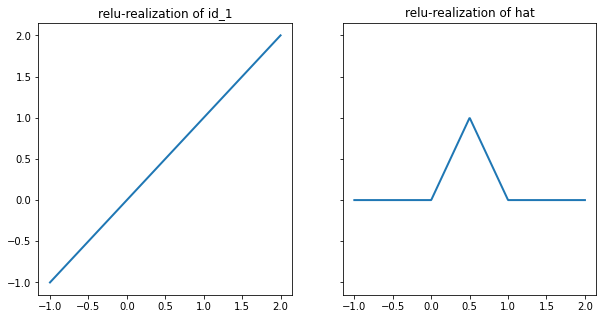

id_1: Depth: 2, Width: 2, Magnitude: 1.0, #Parameters: 7, Connectivity: 4
hat: Depth: 2, Width: 3, Magnitude: 2.0, #Parameters: 10, Connectivity: 8


In [13]:
pa_list = P("id_1"), P("hat")
realizations = [R(pa) for pa in pa_list]
plot_1d(*realizations, titles=[r.name for r in realizations], interval=[-1, 2])
print(*[f"{pa.name}: {pa.describe()}" for pa in pa_list], sep="\n")

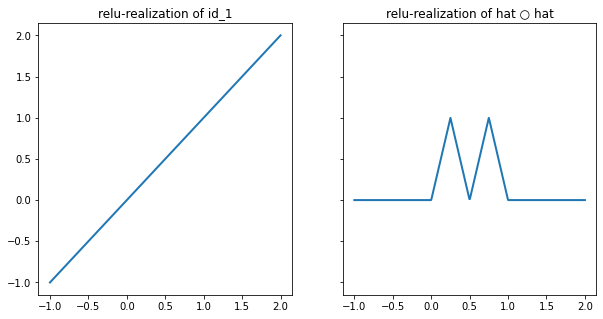

id_1 | Depth: 3, Width: 2, Magnitude: 1.0, #Parameters: 13, Connectivity: 8
hat ○ hat | Depth: 3, Width: 3, Magnitude: 2.0, #Parameters: 22, Connectivity: 19


In [14]:
# elongation of identity to depth 3 and composition of hat function with itself
new_pa_list = nn.elongation(pa_list[0], 3), nn.conc([pa_list[1], pa_list[1]])
realizations = [R(pa) for pa in new_pa_list]
plot_1d(*realizations, titles=[r.name for r in realizations], interval=[-1, 2])
print(*[f"{pa.name} | {pa.describe()}" for pa in new_pa_list], sep="\n")

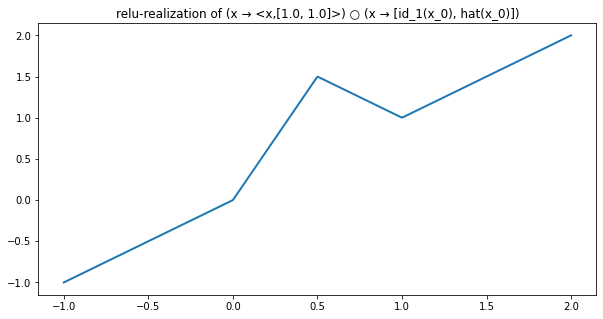

Depth: 2, Width: 5, Magnitude: 2.0, #Parameters: 16, Connectivity: 12


In [15]:
pa = nn.affine_combination([1.0, 1.0], pa_list=pa_list, ind_list=[[0], [0]])
# addition of realization functions -> outputs id(x) + hat(x)
realization = R(pa)
plot_1d(realization, titles=[realization.name], interval=[-1, 2])
print(pa.describe())

In [16]:
# addition of realization functions for separate inputs (x_1, x_2) -> outputs id(x_1) + hat(x_2)
pa = nn.affine_combination([1.0, 1.0], pa_list=pa_list)
pa.arch

[2, 5, 1]

In [17]:
R(pa)([[0.25, 0.25]]).numpy()  # 2-dimensional input

array([[0.75]], dtype=float32)

In [18]:
R(pa)(
    [[1.0, 0.0], [0.25, 0.25]]
).numpy()  # or general: inputs of dimension [batch_size, 2]

array([[1.  ],
       [0.75]], dtype=float32)

In [19]:
D(pa)([[0.25, 0.25]]).numpy()  # derivative of id and hat

array([[1., 2.]], dtype=float32)

## Constructive Approximation Results (in $W^{1,\infty}$ norm)

In the following we show how to approximate a richer class of functions by ReLU networks with "almost optimal" rates (in the spirit of Yarotsky [[4]](https://arxiv.org/abs/1610.01145)).

### Telgarsky Saw-Tooth Construction 

*For any positive integer k, there exist neural networks with $\mathcal{O}(k^3)$  layers, $\mathcal{O}(1)$ nodes per layer, and $\mathcal{O}(1)$ distinct parameters which can not be approximated by networks with $\mathcal{O}(k)$ layers unless they are exponentially large --- they must possess $\Omega(2^k)$ nodes [[7]](https://arxiv.org/abs/1602.04485).*

Each application of the triangle ReLU network doubles the number of "theeth"  $\Rightarrow$  $\color{green}{2^k}$ teeth with $\color{green}{\mathcal{O(k)}}$ network size (layers/parameters)

In [20]:
def plot_sawtooth(k):
    realization = R(nn.conc([P("hat") for _ in range(k)]))
    plot_1d(realization, titles=[realization.name], interval=[-0.5, 1.5], num=int(1e5))


interact(plot_sawtooth, k=(1, 5));

interactive(children=(IntSlider(value=3, description='k', max=5, min=1), Output()), _dom_classes=('widget-inte…

### Yarotsky Squaring Network 

*Proposition 2. The function $f (x) = x^2$ on the segment [0, 1] can be approximated with any
error $\varepsilon > 0$ by a ReLU network having the depth and the number of weights and computation
units $\mathcal{O}(ln(1/\varepsilon))$ [[6]](https://arxiv.org/abs/1610.01145).*

$\big($ lin. interp. of $f$ on intervals of size $2^{-k}$ $\big)$ - $\big($ lin. interp. on intervals of size $2^{-(k+1)}$  $\big) = \big($ scaled saw-thooth function with $2^k$ "theeth" $\big)$

* "on the fly" add the scaled sawthooth functions in an additional node $\Rightarrow$ precision $\color{green}{\mathcal{O}(2^{-k})}$ with ReLU networks of size $\color{green}{\mathcal{O}(k)}$


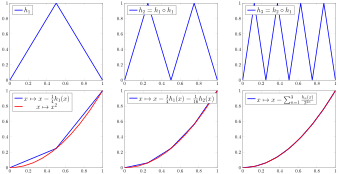

In [21]:
display_svg(SVG("figures/square_approx.svg"))

In [22]:
square = np.poly1d([1, 0, 0])
interact(
    lambda k: plot_1d(
        [R(nn._square(k)), square],
        titles=["approximation of the squaring function"],
        interval=[0, 1],
    ),
    k=(1, 5),
);

interactive(children=(IntSlider(value=3, description='k', max=5, min=1), Output()), _dom_classes=('widget-inte…

*...the same construction can be used when measuring the
approximation error in the $W^{1,\infty}$ norm. In particular, the depth and the number of weights and neurons
of the network do not grow asymptotically faster to satisfy the approximation accuracy with respect to
this stronger norm.* [[4]](https://arxiv.org/abs/1902.07896), [[8]](https://www.sam.math.ethz.ch/sam_reports/counter/ct.php?file=/sam_reports/reports_final/reports2019/2019-07_fp.pdf)

Let $f(x)=x^2$. There are ReLU networks $\Phi_\varepsilon$ of size $\color{green}{\mathcal{O(\log(1/\varepsilon))}}$ satisfying $\color{green}{\|\mathcal{R}\Phi-f \|_{W^{1,\infty}((0,1))} \le \varepsilon}$.

---
**Reminder:** 

$$ W^{n,p}(\Omega):= \{g\in L^p(\Omega): D^\alpha g \in L^p(\Omega)  \quad \forall\alpha\in\mathbb{N}_0^d \quad \text{with} \quad |\alpha|\le n\}$$

$D^\alpha g$ is the $\alpha$-th weak derivatives of $g$, if $$\int_{\Omega} g (D^{\alpha} \phi) = (-1)^{|\alpha|} \int_{\Omega} (D^{\alpha} g) \phi$$ for all $\phi\in C^\infty_c(\Omega)$.



$$\|g\|_{W^{n,\infty}(\Omega)}:=\max_{0\le|\alpha|\le n} \|D^{\alpha} g\|_{L^\infty(\Omega)}$$



$\big($ $\Phi$ approximates $f$ in $W^{1,\infty}$ $\big)$ $\Leftrightarrow$ $\big($ $\mathcal{R}(\Phi)$ and its weak gradient uniformly approximate f and the weak gradient of f , respectively $\big)$

----

Next we extent this approximation to the interval $[-B,B]$ (without altering the magnitude of its parameters or the asymptotic size scaling).

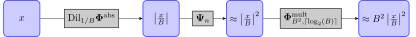

In [23]:
SVG("figures/square.svg")

In [24]:
# visualization of squaring function approximation
interact(
    lambda eps: plot_1d(
        [R(nn.square(eps)), square],
        [D(nn.square(eps)), np.polyder(square)],
        titles=[
            "approximation of the squaring function",
            "approximation of the derivative",
        ],
        interval=[-1, 1],
        sharey=False,
    ),
    eps=(0.1, 1.0),
);

interactive(children=(FloatSlider(value=0.55, description='eps', max=1.0, min=0.1), Output()), _dom_classes=('…

In [25]:
# exploring the squaring function approximation networks
interact(
    lambda eps, bound: print(nn.square(eps, bound=bound).describe()),
    eps=(0.01, 0.1, 0.01),
    bound=(1.0, 100.0),
);
# note that the parameter magnitude is bounded (by leveraging the depth of the network)

interactive(children=(FloatSlider(value=0.05, description='eps', max=0.1, min=0.01, step=0.01), FloatSlider(va…

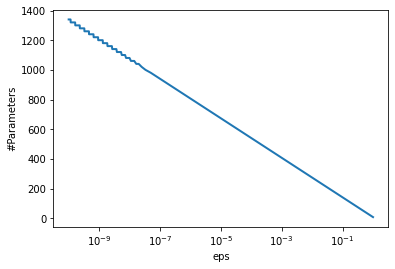

In [26]:
# emprical test of logarithmic parameter scaling
eps = 1 / np.linspace(1, 1e10, num=1000)
y = [nn.square(e).num_parameters for e in eps]
plt.semilogx(eps, y, linewidth=2)
plt.xlabel("eps")
plt.ylabel("#Parameters")
plt.show()

### Multiplication, Polynomials, and Smooth Functions

Combing (composition, linear combination) the squaring networks (and exactly representable easy networks) one gets 
* networks approximating multiplication: $\color{green}{xy=\left|\frac{x+y}{2}\right|^2-\left|\frac{x-y}{2}\right|^2}$
* polynomials 
* functions whose first $n\geq 1$ (weak) derivatives are bounded: local Taylor approximation



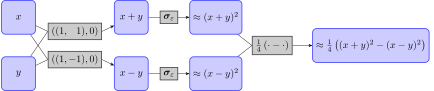

In [27]:
SVG("figures/mult.svg")

In [28]:
# exploring the networks approximating the multiplication function (on [-1,1]!)
interact(
    lambda x, y: print(
        f"Realization of multiplication network at ({x},{y}): {float(R(nn.mult(1e-2, bound=1.))([[x,y]]))}"
    ),
    x=(-1.5, 1.5),
    y=(-1.5, 1.5),
);

interactive(children=(FloatSlider(value=0.0, description='x', max=1.5, min=-1.5), FloatSlider(value=0.0, descr…

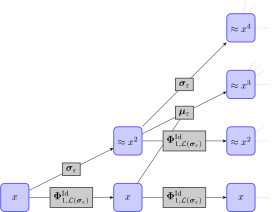

In [29]:
SVG("figures/monomials.svg")

In [30]:
# Testing the output
interact(
    lambda x, const: print(
        f"Realization of monomial network at {x}: {R(nn.monomial(3, 0.1, bound=10., const=const))([[x]]).numpy()[0]}"
    ),
    const=True,
    x=(-10.0, 10.0),
);

interactive(children=(FloatSlider(value=0.0, description='x', max=10.0, min=-10.0), Checkbox(value=True, descr…

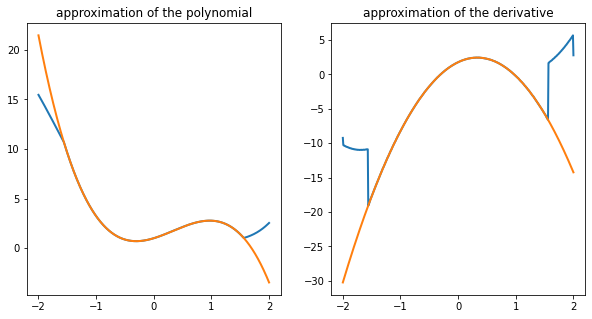

In [31]:
# visualization of polynomial approximation
p = [-2.0, 2.0, 1.77, 1.0]
poly = np.poly1d(p)
pa = nn.poly(p, eps=1.0)  # as this are worst case estimates, eps can be rather large
plot_1d(
    [R(pa), poly],
    [D(pa), np.polyder(poly)],
    titles=[f"approximation of the polynomial", "approximation of the derivative"],
    interval=[-2, 2],
    sharey=False,
)

In [32]:
pa.describe()

'Depth: 34, Width: 16, Magnitude: 4.0, #Parameters: 3325, Connectivity: 771'

### Theoretical Results 

**...for classes of Sobolev-regular functions:** [[4]](https://arxiv.org/abs/1902.07896)

There exists $c=c(d,n,B)> 0$ such that for every $\varepsilon > 0$ and every
$$f\in\{g\in W^{n,\infty}((0,1)^d): \|g\|_{W^{n,\infty}((0,1)^d)}\le B\}$$
there exists a ReLU network $\Phi$ with
$$\|\mathcal{R}\Phi-f \|_{W^{1,\infty}((0,1)^d)} \le \varepsilon$$
and
$$Depth(\Phi)\le c \cdot log(\varepsilon^{-n/(n-1)}), \quad Connectivity(\Phi)\le  c \cdot \varepsilon^{-d/(n-1)} \cdot log^2(\varepsilon^{-n/(n-1)}).$$

Corresponding results for:

* fractional Sobolev spaces $W^{s,p}$ with $0\le s \le 1$ (Banach space interpolation argument) and $1\le p \le \infty$
* any continuous piecewise linear activation function with $1\le M < \infty$ breakpoints
* lower bound: $Connectivity(\Phi)\ge  c \cdot \varepsilon^{-d/2(n-1)}$


In [33]:
# You can try to construct this networks (perhaps for d=1) using our framework
# 1. construct partition of unity
# 2. predefine derivatives of f (or use automatic differentiation frameworks)
# 3. use the neural network approximating polynomials
#
#
#
#
#
#
#
#
#
#
#
#

## Additional Material

### ReLU derivative

**Problem: Classical Chain-Rule fails!**

...although all ReLU networks are a.e. differentiable.

Very simple counterexample: 

$u(x):=\operatorname{ReLU}(x)$

$v(x):=0$ 

formally apply the chain rule: $$D(u\circ v)(x)=\color{blue}{D u(v(x))}\cdot D v(x)$$

$D u(y)$ is well-defined for all $y\neq 0$, but the expression $\color{blue}{D u(v(x))}$ is not defined for any $x\in\mathbb{R}$.


**Inner function maps a set of positive measure into a set where the derivative of the outer function does not exist.**


**What happens in PyTorch / Tensorflow when computing the gradients in the back-propagation (as this is based on the chain-rule)??**

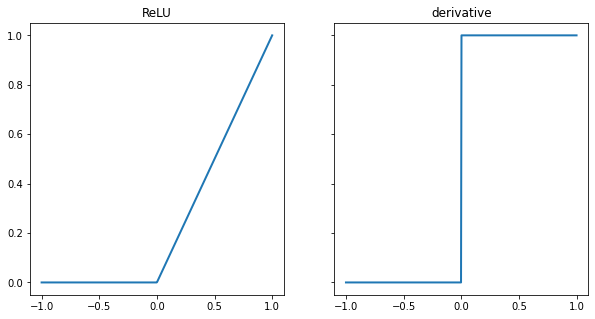

In [34]:
act = P(
    [(np.array([[1.0]]), np.array([0.0])), (np.array([[1.0]]), np.array([0.0]))],
    name="act",
)
plot_1d(R(act), D(act), titles=["ReLU", "derivative"])

In [35]:
float(D(act)([[0.0]]))

0.0

The derivative of the ReLU at zero is set to zero in PyTorch and Tensorflow, i.e.
$\color{blue}{\frac{\partial \operatorname{ReLU}}{\partial x}(x) :=1_{(0,\infty)}(x)}$.

Note that the chain rule holds by definition everywhere, i.e. 

 $$\color{green}{\mathcal{D}(\Psi\circ\Phi)=\mathcal{D}\Psi(\mathcal{R}\Phi)\cdot\mathcal{D}\Phi}$$

and, furthermore, $\color{green}{\mathcal{D}\Phi=D\mathcal{R}\Phi \quad a.e.}$



**However:** On the nullset the derivative can be arbitrary wrong, e.g. take the network $\Phi=\left(\left( (1 , -1 ),(0 ,0)\right),\left( \left(\begin{matrix} a \\-b \end{matrix}\right),0\right)\right)$ then it holds:

1. $\mathcal{R}\Phi(x)=a\operatorname{ReLU}(x)-b\operatorname{ReLU}(-x)=\begin{cases}  bx, &x< 0 \\  ax, &x\ge 0 \end{cases}$
2. $ \mathcal{D}\Phi(x)=\begin{cases}  b, &x< 0 \\  a, & x> 0 \\ \color{blue}0, & x=0\end{cases}$

In [36]:
def plot_print(a, b):
    pa = P(
        [
            (np.array([[1.0, -1.0]]), np.array([0, 0])),
            (np.array([[a], [-b]]), np.array([0.0])),
        ]
    )
    plot_1d(
        R(pa), D(pa), sharey=False, titles=[f"{a}ReLU(x) - {b}ReLU(x)", "derivative"]
    )
    print(f"Derivative at x=0: {float(D(pa)([[0.]]))}")


interact(plot_print, a=(1.0, 2.0), b=(1.0, 2.0));

interactive(children=(FloatSlider(value=1.5, description='a', max=2.0, min=1.0), FloatSlider(value=1.5, descri…

For convex $\mathcal{R}\Phi$ the values of $\mathcal{D}\Phi$ on the nullset do not necessarily lie in the respective subdifferentials of $\mathcal{R}\Phi$.

The next figure illustrates this by showing the behavior of the (backpropagated) derivative of the neural network approximating the squaring function.

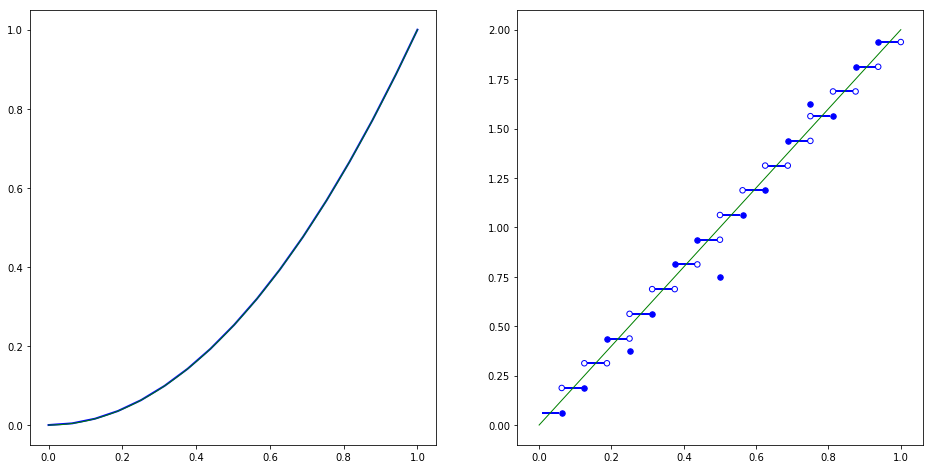

In [37]:
Image("figures/squaring_der.png")

Although our results hold regardless of which value is chosen for the derivative of $\operatorname{ReLU}$ at the origin, no choice will guarantee that all values of $\mathcal{D} \Phi$ lie in the respective subdifferentials of $\mathcal{R}\Phi$ (e.g., additionally consider $x \mapsto ReLU(-ReLU(x))$)

### Global (Pointwise) Error Estimates

For suitable functions $f$ with at most polynomially growing derivative we want ReLU networks $\Phi_\varepsilon$ with:


$$ 
|f(x)-\mathcal{R}{\Phi_\varepsilon}(x)|\le \varepsilon(1+\|x\|^{\kappa}_2) \quad \color{blue}{x\in\mathbb{R}^d}
$$
$$
    \|D f(x) -\mathcal{D}\Phi_\varepsilon(x)\|_2 \le C\varepsilon^r(1+\|x\|_2^{\kappa}) \quad \color{blue}{a.e. \ x\in\mathbb{R}^d}
$$

Idea:
1. ReLU networks $\Phi_{\varepsilon,B}$ with $\|\mathcal{R}\Phi-f \|_{W^{1,\infty}((-B,B)^d)} \le \varepsilon$
2.  ReLU network $\Phi_B^{\operatorname{char}}$ which represents the $d$-dimensional approximate characteristic function of $[-B,B]^d$ [[3]](https://arxiv.org/abs/1809.07669)
3. ReLU network $\Phi_{\varepsilon,b}^{\operatorname{mult}}$ approximating the multiplication function on $[-b,b]^2$ with error $\varepsilon$
4. Define the global approximation networks $\Phi_\varepsilon$ as the composition of $\Phi_{\varepsilon/2,b_\varepsilon}^{\operatorname{mult}}$ with the parallelization of $\Phi_{B_\varepsilon}^{\operatorname{char}}$ and $\Phi_{\varepsilon/2,B_\varepsilon+1}$ for suitable 

\begin{equation}
    B_\varepsilon\in \mathcal{O}(\varepsilon^{-1}) \quad \text{and} \quad b_\varepsilon\in \mathcal{O}(\varepsilon^{-\nu}).
\end{equation}


In [38]:
# You can also try to construct this networks (perhaps for d=1) using our framework
#
#
#
#
#
#
#
#
#
#
#
#